In [7]:
import pandas as pd
import random
import os

# Create output directory if not exists
os.makedirs("data", exist_ok=True)

def load_and_clean_dataset(path="data/dataset.csv"):
    print("[INFO] Loading dataset...")
    df = pd.read_csv(path)

    # Combine symptom columns into a single list column
    symptom_cols = [f"Symptom_{i}" for i in range(1, 18)]
    df["Symptoms"] = df[symptom_cols].values.tolist()

    # Clean and deduplicate symptoms
    df["Symptoms"] = df["Symptoms"].apply(
        lambda x: sorted(set([i.lower().strip().replace('_', ' ') for i in x if isinstance(i, str)]))
    )
    df = df[df["Symptoms"].map(len) > 0]  # Remove empty symptom rows

    # Drop unneeded columns
    df = df[["Disease", "Symptoms"]]

    # Drop exact duplicates (convert to tuple first)
    df["Symptoms"] = df["Symptoms"].apply(tuple)
    df.drop_duplicates(inplace=True)
    df["Symptoms"] = df["Symptoms"].apply(list)  # back to list

    print(f"[INFO] Unique diseases: {df['Disease'].nunique()}")
    print(f"[INFO] Rows after cleaning: {len(df)}")

    return df

def augment_symptom_variations(df):
    print("[INFO] Augmenting data with symptom variations...")
    augmented_rows = []

    for _, row in df.iterrows():
        disease = row["Disease"]
        symptoms = row["Symptoms"]

        for _ in range(random.randint(2, 3)):
            num_symptoms = random.randint(max(2, len(symptoms) // 2), len(symptoms))
            sampled = random.sample(symptoms, num_symptoms)
            augmented_rows.append({"Disease": disease, "Symptoms": sorted(sampled)})

    df_aug = pd.DataFrame(augmented_rows)

    # Drop duplicates again (convert list to tuple)
    df_aug["Symptoms"] = df_aug["Symptoms"].apply(tuple)
    df_aug.drop_duplicates(inplace=True)
    df_aug["Symptoms"] = df_aug["Symptoms"].apply(list)

    print(f"[INFO] Final augmented data size: {len(df_aug)}")
    return df_aug

def main():
    df_clean = load_and_clean_dataset("data/dataset.csv")
    df_augmented = augment_symptom_variations(df_clean)

    output_path = "data/cleaned_augmented_disease_data.csv"
    df_augmented.to_csv(output_path, index=False)
    print(f"[INFO] Cleaned & augmented dataset saved to: {output_path}")

if __name__ == "__main__":
    main()

[INFO] Loading dataset...
[INFO] Unique diseases: 41
[INFO] Rows after cleaning: 304
[INFO] Augmenting data with symptom variations...
[INFO] Final augmented data size: 676
[INFO] Cleaned & augmented dataset saved to: data/cleaned_augmented_disease_data.csv


In [8]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
import joblib
import os

# Ensure model folder exists
os.makedirs("model", exist_ok=True)

# Load cleaned data
df = pd.read_csv("data/cleaned_augmented_disease_data.csv")
df["Symptoms"] = df["Symptoms"].apply(eval)  # Convert stringified lists back to real lists

# Encode symptoms
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df["Symptoms"])
y = df["Disease"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models
rf = RandomForestClassifier(random_state=42)
nb = MultinomialNB()

# Train models
rf.fit(X_train, y_train)
nb.fit(X_train, y_train)

# Evaluate models
def evaluate(model, name):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="weighted")
    print(f"\n📊 {name} Results")
    print(f"   Accuracy: {acc:.4f}")
    print(f"   F1 Score: {f1:.4f}")
    return acc, f1

rf_acc, rf_f1 = evaluate(rf, "Random Forest")
nb_acc, nb_f1 = evaluate(nb, "Naive Bayes")

# Save the best model based on F1 score
best_model = rf if rf_f1 >= nb_f1 else nb
model_name = "Random Forest" if rf_f1 >= nb_f1 else "Naive Bayes"
joblib.dump(best_model, "model/best_model.pkl")
joblib.dump(mlb, "model/mlb.pkl")

print(f"\n✅ Saved best model: {model_name} in 'model/best_model.pkl'")
print("✅ Symptom encoder saved as 'model/mlb.pkl'")


📊 Random Forest Results
   Accuracy: 0.9853
   F1 Score: 0.9857

📊 Naive Bayes Results
   Accuracy: 0.9485
   F1 Score: 0.9438

✅ Saved best model: Random Forest in 'model/best_model.pkl'
✅ Symptom encoder saved as 'model/mlb.pkl'


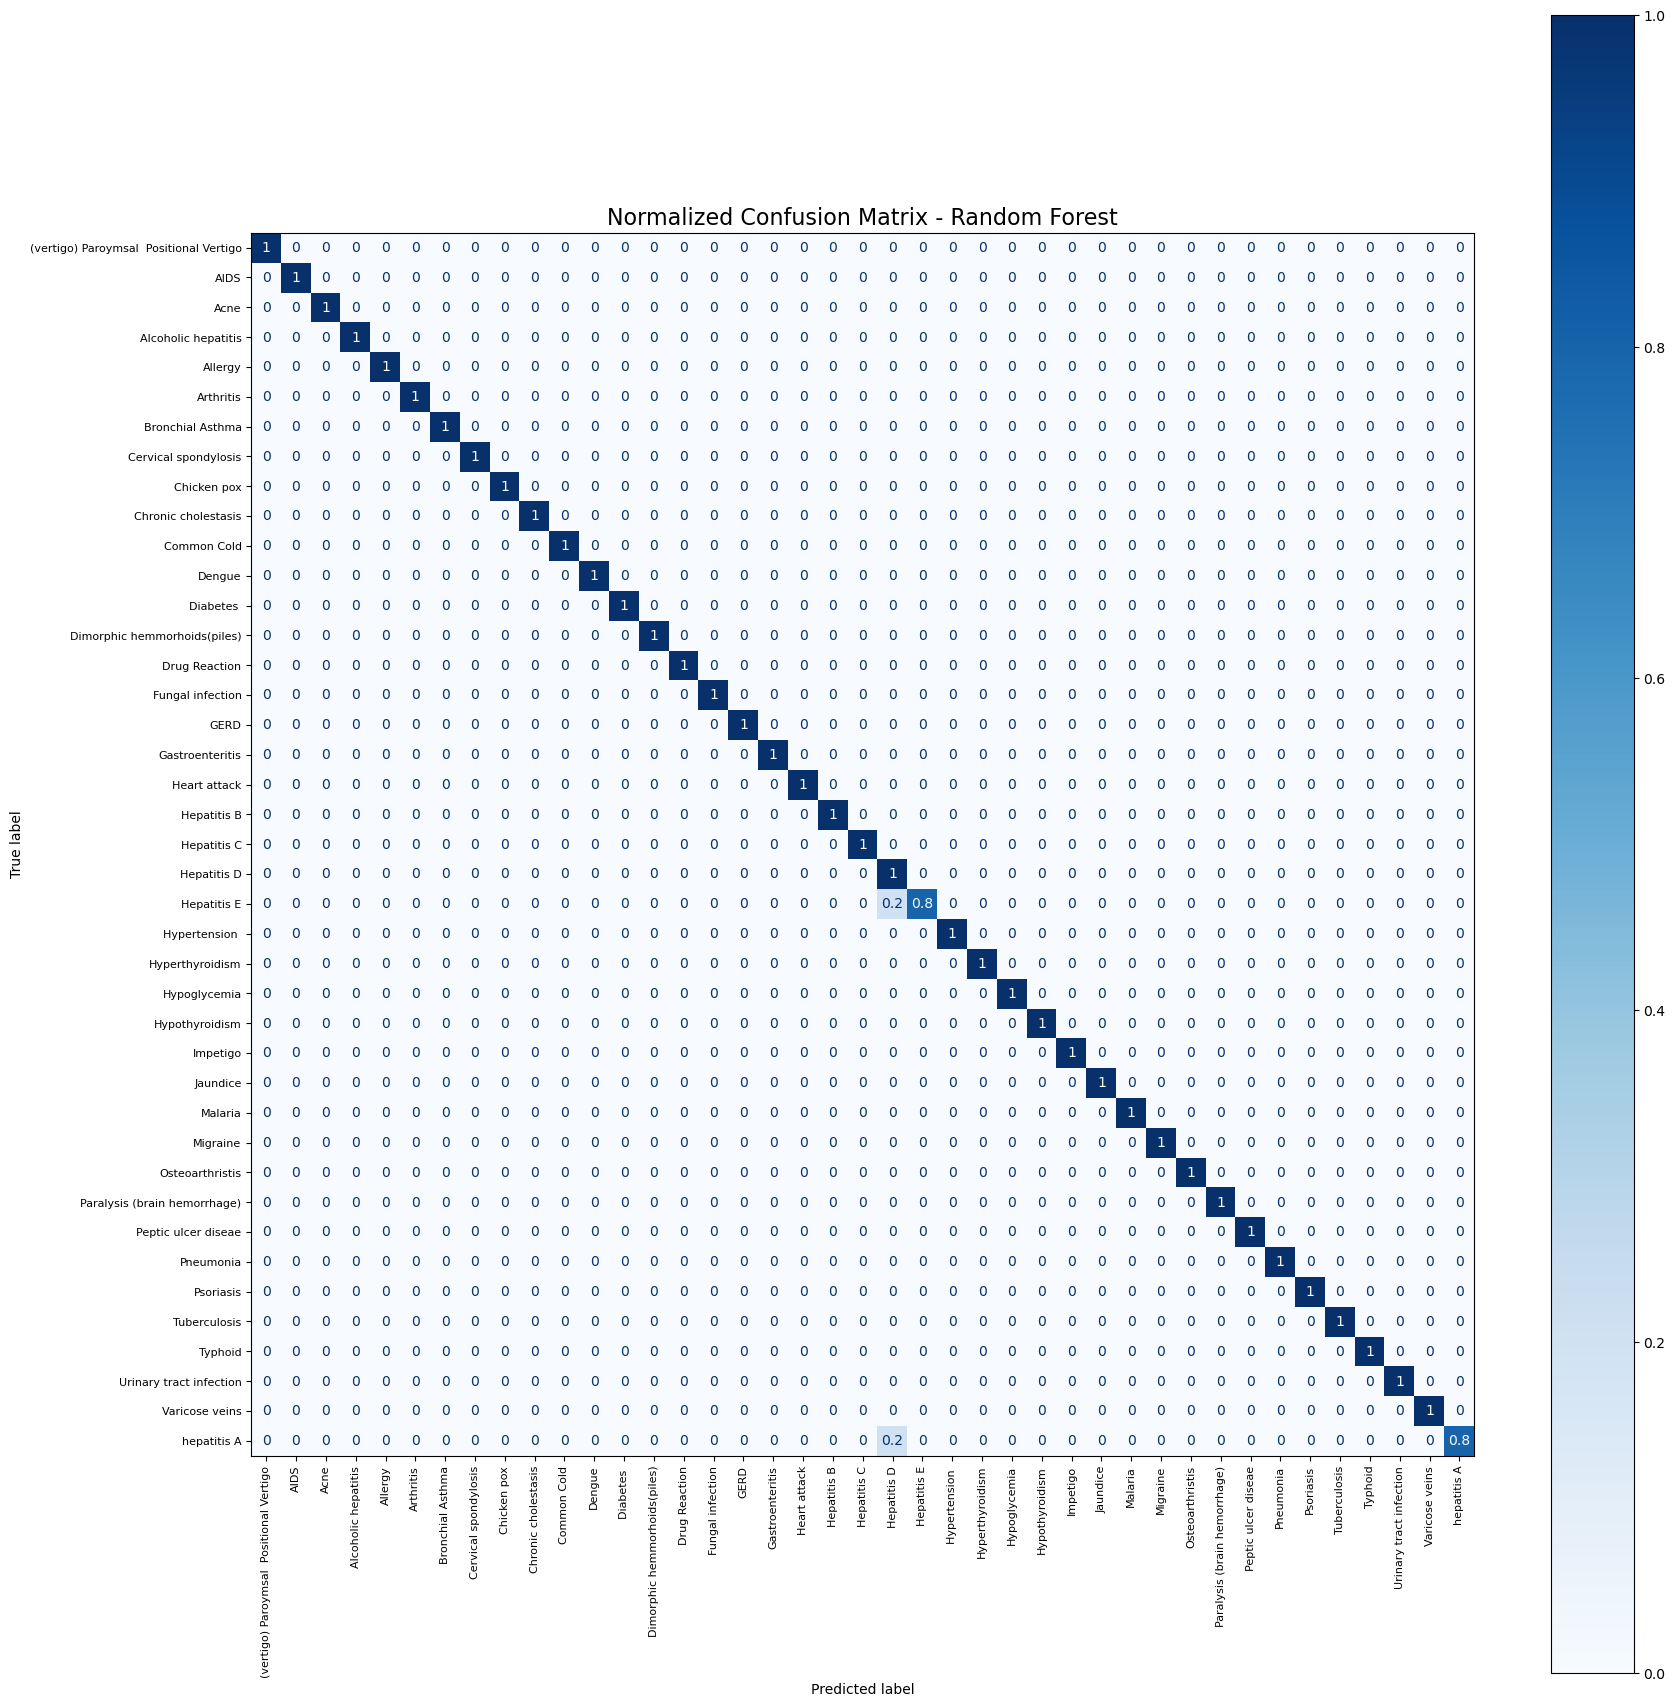

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = best_model.predict(X_test)

# Confusion matrix (normalized)
cm = confusion_matrix(y_test, preds, labels=best_model.classes_, normalize='true')

# Set up a larger, clearer plot
fig, ax = plt.subplots(figsize=(18, 18))  # Bigger figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(
    ax=ax,
    xticks_rotation=90,
    cmap='Blues',
    colorbar=True
)
plt.title(f"Normalized Confusion Matrix - {model_name}", fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(f"model/normalized_confusion_matrix_{model_name.replace(' ', '_').lower()}.png")
plt.show()